In [12]:
from download_websites import download_websites
from generate_scraping_tasks import generate_scraping_tasks
from generate_solution_code import generate_solution_code
from extract_html_info import extract_relevant_information

import pandas as pd
import os
import json

In [13]:
websites_csv = 'websites.csv'
save_folder = 'downloaded_pages'
ROWS = (0, 10000)
NUM_TASKS_PER_WEBSITE = 10

# Download websites
# download_websites(websites_csv, save_folder)

# Generate scraping tasks and solutions
websites = pd.read_csv(websites_csv)

for i, row in websites.iterrows():
    if i < ROWS[0] or i > ROWS[1]:
        continue
    
    print("--------------------")

    category, website, link = row
    HTML_file = f'{save_folder}/{website}.html'

    if os.path.exists(f'solution_code/{website}'):
        print(f'{website} already has data')
        continue

    if not os.path.exists(HTML_file):
        print(f'{website}.html does not exist')
        continue

    print(f"Generating data for {website}")

    HTML_elements = extract_relevant_information(HTML_file)
    with open(f'extracted_info/{website}.txt', 'w') as f:
        f.write(HTML_elements)
    
    print(f'Extracted HTML elements for {website}')

    generate_scraping_tasks(link, website, category, HTML_elements, NUM_TASKS_PER_WEBSITE)
    with open(f'scraping_tasks/{website}.txt', 'r') as f:
        scraping_tasks = pd.DataFrame([{'task': task} for task in f.readlines()])
    
    print(f'Generated scraping tasks for {website}')

    for j, task_name in scraping_tasks.iterrows():
        task_name = task_name['task']
        generate_solution_code(website, HTML_file, category, HTML_elements, task_name, j)
    
    print(f'Generated solutions for {website}')

print("--------------------")

--------------------
reddit already has data
--------------------
homefinder already has data
--------------------
espn already has data
--------------------
washingtonpost already has data
--------------------
merchantcircle already has data
--------------------
census already has data
--------------------
ppubs already has data
--------------------
tumblr already has data
--------------------
nasdaq already has data
--------------------
finviz already has data
--------------------
aljazeera already has data
--------------------
indeed already has data
--------------------
foxnews already has data
--------------------
seekingalpha already has data
--------------------
careerbuilder already has data
--------------------
redfin already has data
--------------------
ziprecruiter already has data
--------------------
bestbuy already has data
--------------------
fifa already has data
--------------------
aboutus already has data
--------------------
data already has data
-----------------

In [ ]:
# Combine all scraping tasks and solutions into one file

# Load prompts
system_prompt = open('prompts/generate_solution_code_system_prompt.txt', 'r').read()
user_prompt = open('prompts/generate_solution_code_user_prompt.txt', 'r').read()

# Load extracted info
extracted_info = {}
for filename in os.listdir('extracted_info'):
    with open(f'extracted_info/{filename}', 'r') as f:
        extracted_info[filename.split('.')[0]] = f.read()
    
# Load scraping tasks
scraping_tasks = {}
for filename in os.listdir('scraping_tasks'):
    with open(f'scraping_tasks/{filename}', 'r') as f:
        scraping_tasks[filename.split('.')[0]] = f.readlines()

# Load solutions
solutions = {}
for folder in os.listdir('solution_code'):
    solutions[folder] = {}
    for filename in os.listdir(f'solution_code/{folder}'):
        with open(f'solution_code/{folder}/{filename}', 'r') as f:
            solutions[folder][filename.split('.')[0]] = f.read()

# Load website infos
websites = pd.read_csv('websites.csv')

# Generate prompts
prompts = {} # Dictionary of dictionaries
categories = {}
links = {}
for i, row in websites.iterrows():
    category, website, link = row
    categories[website] = category
    links[website] = link
    if website not in scraping_tasks:
        print(f'{website} does not have generated data')
        continue
    scraping_tasks_website = scraping_tasks[website]
    HTML_file = f'downloaded_pages/{website}.html'
    prompts[website] = {}
    for j, scraping_task in enumerate(scraping_tasks_website):
        scraping_task = scraping_task.strip()
        solution = solutions[website][f'{website}_{j}']
        HTML_elements = extracted_info[website]
        prompts[website][f'{website}_{j}'] = user_prompt.format(website=website, HTML_file=HTML_file, category=category, HTML_string=HTML_elements, task=scraping_task)

# Generate training samples
training_samples = {}
sample_template = """### System:
{system_prompt}

### User:
{user_prompt}

### Response:
```
{response}
```
"""
system_prompt = open('prompts/generate_solution_code_system_prompt.txt', 'r').read()
for website in prompts:
    training_samples[website] = {}
    for task_name in prompts[website]:
        sample = sample_template.format(system_prompt=system_prompt, user_prompt=prompts[website][task_name], response=solutions[website][task_name])
        training_samples[website][task_name] = sample

# Convert prompts, solutions and training samples to lists
websites_list = []
task_names_list = []
categories_list = []
links_list = []
prompts_list = []
solutions_list = []
training_samples_list = []
for website in prompts:
    for task_name in prompts[website]:
        websites_list.append(website)
        task_names_list.append(task_name)
        categories_list.append(categories[website])
        links_list.append(links[website])
        prompts_list.append(prompts[website][task_name])
        solutions_list.append(solutions[website][task_name])
        training_samples_list.append(training_samples[website][task_name])

# Combine to a list of dictionaries
data = []
for i in range(len(prompts_list)):
    data.append({
        'website': websites_list[i],
        'task': task_names_list[i],
        'category': categories_list[i],
        'link': links_list[i],
        'prompt': prompts_list[i],
        'solution': solutions_list[i],
        'training_sample': training_samples_list[i]
    })
print("Dataset length:", len(data))

# Save prompts, solutions and training samples as a json file
# where each 'row' is a prompt, solution and training sample
# for a particular website and task
with open('dataset.json', 'w') as f:
    json.dump(data, f)

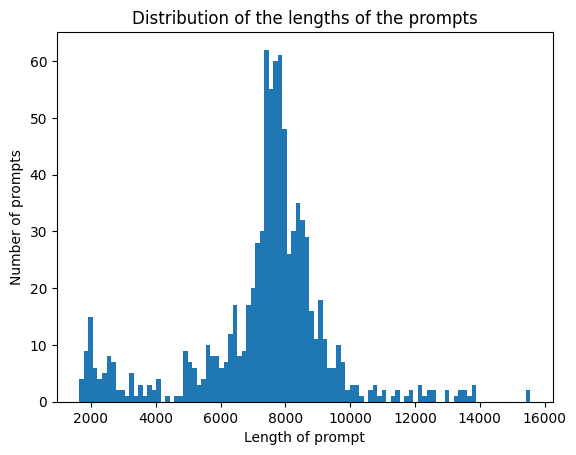

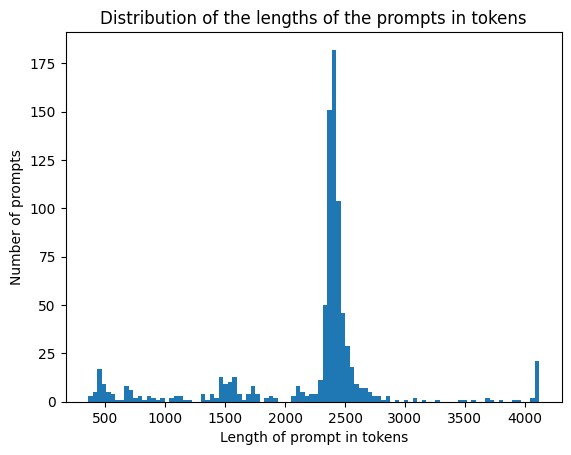

In [9]:
import matplotlib.pyplot as plt

# Load dataset from json file
with open('dataset.json', 'r') as f:
    data = json.load(f)

# Calculate the distribution of the lengths of the prompts ("training_sample")
lengths = []
for row in data:
    lengths.append(len(row['training_sample']))
plt.hist(lengths, bins=100)
plt.xlabel("Length of prompt")
plt.ylabel("Number of prompts")
plt.title("Distribution of the lengths of the prompts")
plt.show()

# Calculate the distribution of the lengths of the prompts in tokens using the tokenizer
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
lengths = []
for row in data:
    lengths.append(len(encoding.encode(row['training_sample'])))
plt.hist(lengths, bins=100)
plt.xlabel("Length of prompt in tokens")
plt.ylabel("Number of prompts")
plt.title("Distribution of the lengths of the prompts in tokens")
plt.show()

In [ ]:
loaded_data = json.load(open('dataset.json', 'r'))
# print("Loaded data length:", len(loaded_data))
# print("Website:", loaded_data[0]['website'])
# print("Task:", loaded_data[0]['task'])
# print("Category:", loaded_data[0]['category'])
# print("Link:", loaded_data[0]['link'])
# print("Prompt:\n" + loaded_data[0]['prompt'])
# print("Solution:", loaded_data[0]['solution'])
print("Training sample:", loaded_data[0]['training_sample'])

In [ ]:
loaded_data[0]